In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 

# Data Cleaning

In [2]:
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

In [3]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]
#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)
pitches.reset_index(inplace=True)
#finds 'UN' in pitches and drops those rows
UN_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(UN_mask, inplace=True)
#gets rid of po because it is the same as fo
pitches['pitch_type'].replace('PO', 'FO', inplace=True)

In [5]:
#reads in other csvs
atbats = pd.read_csv('../data/atbats.csv', low_memory=False)
games = pd.read_csv('../data/games.csv', low_memory=False)
names = pd.read_csv('../data/player_names.csv', low_memory=False)

In [13]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')
#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_events = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [16]:
pitchers_top500 = final_events.groupby('pitcher_name').count().sort_values('batter_name', ascending=False).iloc[:500, 0].index
#grabs all 500 top pitchers
df_500_events = final_events[final_events['pitcher_name'].isin(pitchers_top500)]

## Reading in Accuracy of Pitchers

In [18]:
#reading in the csv of accuracy from each pitcher which was form pitchers_outcomes notebook 
df_accuracy_pitchers = pd.read_csv('../Models/dt_pitcher_accuracy.csv')
#renames columns correctly
df_accuracy_pitchers.columns = ['name', 'accuracy', 'num_pitches']

Text(0.5, 1.0, 'CV Accuracy scores of all pitchers')

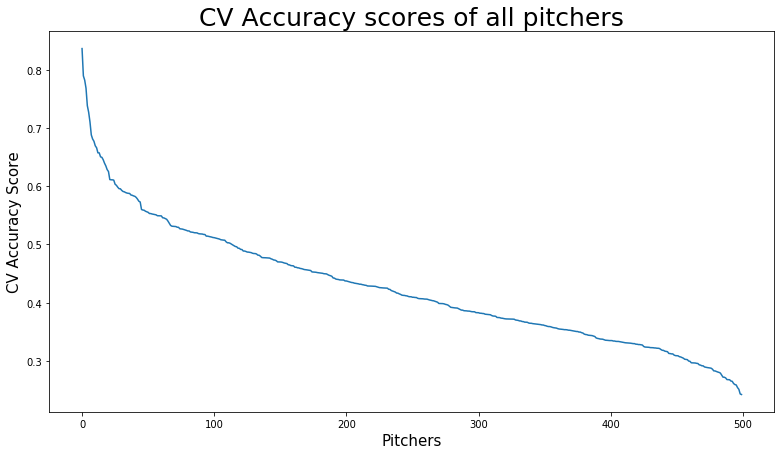

In [77]:
plt.figure(figsize=(13, 7))
plt.plot(np.arange(500), df_accuracy_pitchers.sort_values('accuracy', ascending=False)['accuracy'].values)
plt.xlabel('Pitchers', size=15)
plt.ylabel('CV Accuracy Score', size=15)
plt.title('CV Accuracy scores of all pitchers', size=25)

Text(0.5, 1.0, 'CV Accuracy scores of all pitchers')

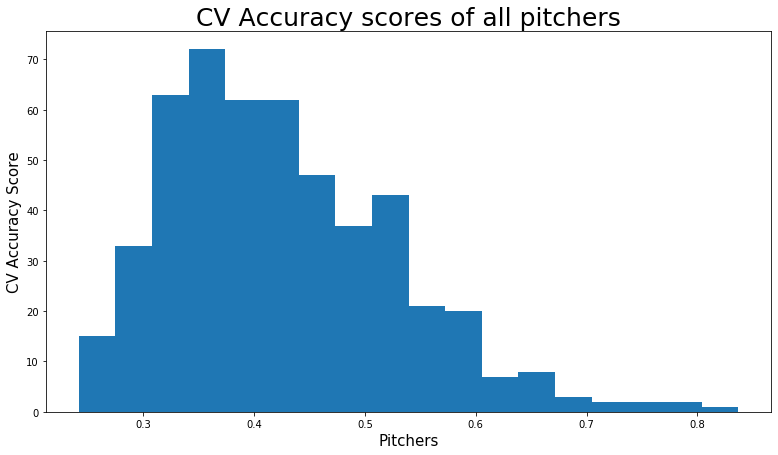

In [78]:
plt.figure(figsize=(13, 7))
plt.hist(df_accuracy_pitchers['accuracy'].values, bins='fd')
plt.xlabel('Pitchers', size=15)
plt.ylabel('CV Accuracy Score', size=15)
plt.title('CV Accuracy scores of all pitchers', size=25)

## Calculating BAA for all pitchers

In [26]:
#this cell takes each pitcher name and calculates a baa 

lst_baa = []
for name in df_accuracy_pitchers['name']:
    events = df_500_events[df_500_events['pitcher_name'] == name].groupby('event').count().iloc[:, 0]
    hits = 0
    denom = np.sum(events)
    if 'Intent Walk' in events.index:
        denom -= events['Intent Walk']
    if 'Walk' in events.index:
        denom -= events['Walk']
    if 'Sac Bunt' in events.index:
        denom -= events['Sac Bunt']
    if 'Sac Fly' in events.index:
        denom -= events['Sac Fly']
    if 'Hit By Pitch' in events.index:
        denom -= events['Hit By Pitch']
    if 'Single' in events.index:
        hits += events['Single']
    if 'Double' in events.index:
        hits += events['Double']
    if 'Home Run' in events.index:
        hits += events['Home Run']
    if 'Triple' in events.index:
        hits += events['Triple']
        
    lst_baa.append(hits/denom)

In [29]:
df_accuracy_pitchers['batting_avg_agnst'] = lst_baa   #puts baa into df 

In [32]:
#lets sort it so we can find any trends between accuracy and baa
df_accuracy_pitchers.sort_values('accuracy', inplace=True)
#resets index, due to the merge needs a little more cleaning
df_accuracy_pitchers.reset_index(inplace=True)
#drops 'index' column from the reset_index
df_accuracy_pitchers.drop(columns='index', inplace=True)

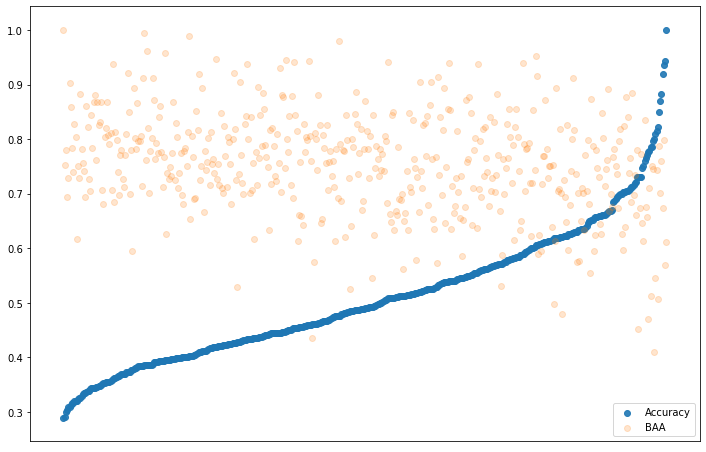

In [39]:
#lets plot the baa and the accuracy 
plt.figure(figsize=(12,8))
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['accuracy']/np.max(df_accuracy_pitchers['accuracy']), alpha=0.9, label='Accuracy')
plt.xticks([])
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['batting_avg_agnst']/np.max(df_accuracy_pitchers['batting_avg_agnst']), alpha=0.2, label='BAA')
plt.legend()
#plt.plot(sm_results.params[0] + x * sm_results.params[1], c='k', label='OLS BAA Regression')

In [41]:
#fitting linear regression to the baa values for each pitcher
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

X = sm.add_constant(np.arange(500))
y = df_accuracy_pitchers['batting_avg_agnst']/np.max(df_accuracy_pitchers['batting_avg_agnst'])

simple_linear = OLS(y, X)
sm_results = simple_linear.fit()
sm_results.summary()
#sm_results.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      batting_avg_agnst   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     46.83
Date:                Sat, 29 Feb 2020   Prob (F-statistic):           2.28e-11
Time:                        14:12:59   Log-Likelihood:                 490.97
No. Observations:                 500   AIC:                            -977.9
Df Residuals:                     498   BIC:                            -969.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8027      0.008     98.963      0.000       0.787       0.819
x1            -0.0002   2.81e-05     -6.843      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        5.043   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.066
Skew:                          -0.182   Prob(JB):                       0.0794
Kurtosis:                       3.333   Cond. No.                         576.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

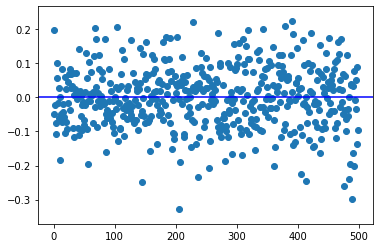

In [84]:
plt.scatter(x, sm_results.resid.values)
plt.axhline(0, c='b')

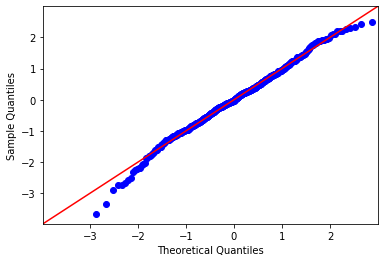

In [86]:
stud_resid = sm_results.outlier_test()['student_resid'].values

ax = sm.graphics.qqplot(stud_resid, line='45')

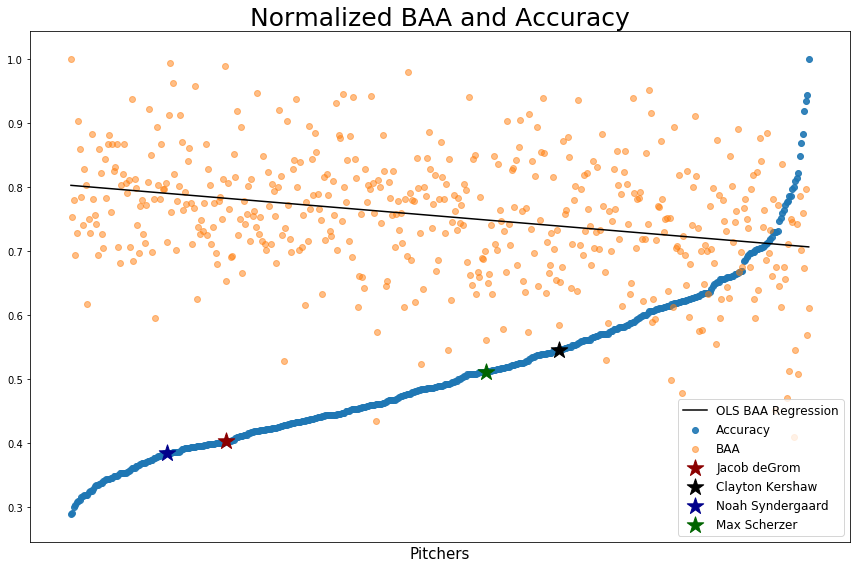

In [83]:
#lets plot it to see 
plt.figure(figsize=(12,8))
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['accuracy']/np.max(df_accuracy_pitchers['accuracy']), alpha=0.9, label='Accuracy')
plt.xticks([])
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['batting_avg_agnst']/np.max(df_accuracy_pitchers['batting_avg_agnst']), alpha=0.5, label='BAA')
x = np.arange(500)
plt.plot(sm_results.params[0] + x * sm_results.params[1], c='k', label='OLS BAA Regression')

plt.scatter(df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Jacob deGrom'].index, df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Jacob deGrom']['accuracy']/np.max(df_accuracy_pitchers['accuracy']), marker= '*', c='darkred', s=300, label='Jacob deGrom')
plt.scatter(df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Clayton Kershaw'].index, df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Clayton Kershaw']['accuracy']/np.max(df_accuracy_pitchers['accuracy']), marker= '*', c='k', s=300, label='Clayton Kershaw')
plt.scatter(df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Noah Syndergaard'].index, df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Noah Syndergaard']['accuracy']/np.max(df_accuracy_pitchers['accuracy']), marker='*', c='darkblue', s=300, label='Noah Syndergaard')
plt.scatter(df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Max Scherzer'].index, df_accuracy_pitchers[df_accuracy_pitchers['name'] == 'Max Scherzer']['accuracy']/np.max(df_accuracy_pitchers['accuracy']), marker='*', c='darkgreen', s=300, label='Max Scherzer')
plt.legend(loc='lower right')

plt.title('Normalized BAA and Accuracy', size=25)
plt.xlabel('Pitchers', size=15)
plt.legend(fontsize='large', loc='lower right')
plt.tight_layout()
plt.savefig('../Graphics/baa_accuracy_all500.png')

## Make vectors of distribution of pitch type for each pitcher

In [47]:
#creating empty df with pitch types as columns
pitchers_vectors = pd.DataFrame(columns=df_500_events['pitch_type'].unique())

In [49]:
#this cell calculates a vector for each pitcher as a representation for the types of pitches they throw
#and how often they throw them.

for i, name in enumerate(df_accuracy_pitchers['name']):  #loops through all different pitchers
    #groups by pitch type for each pitcher
    x = df_500_events[df_500_events['pitcher_name'] == name].groupby('pitch_type').count().iloc[:, 0]
    x = x / x.sum()  #normalizes this series
    pitcher_row = x.to_frame().T  #makes a df and transposes it
    pitcher_row['name'] = i  #creates another column for name
    pitchers_vectors = pd.concat((pitchers_vectors, pitcher_row))  #concats to pitchers_vectors dataframe

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [55]:
pitchers_vectors

,AB,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,SC,SI,SL,name
batter_name,NaN,0.162837,0.162837,0.002377,NaN,0.148970,0.293978,NaN,NaN,NaN,0.001585,NaN,NaN,NaN,0.172345,0.055071,0.0
batter_name,NaN,0.170883,0.172884,NaN,NaN,0.232211,0.195996,NaN,0.006187,0.221656,0.000182,NaN,NaN,NaN,NaN,NaN,1.0
batter_name,NaN,NaN,0.081224,NaN,NaN,0.081791,0.186815,0.000756,0.196827,NaN,0.002267,NaN,NaN,NaN,0.287117,0.163204,2.0
batter_name,NaN,NaN,0.056099,NaN,NaN,0.070387,0.151323,0.000096,0.284139,NaN,NaN,NaN,NaN,NaN,0.151323,0.286632,3.0
batter_name,NaN,0.196233,0.003890,NaN,0.000102,0.144744,0.276384,NaN,NaN,0.203706,0.000409,NaN,NaN,NaN,NaN,0.174532,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batter_name,NaN,0.002279,NaN,NaN,NaN,0.828129,0.003647,0.000228,NaN,NaN,0.002507,NaN,NaN,NaN,NaN,0.163209,495.0
batter_name,NaN,0.021732,NaN,NaN,NaN,NaN,0.848580,NaN,NaN,NaN,0.005608,NaN,NaN,NaN,NaN,0.124080,496.0
batter_name,NaN,NaN,NaN,0.022909,NaN,NaN,0.134748,0.000113,NaN,NaN,0.000226,NaN,0.842004,NaN,NaN,NaN,497.0
batter_name,NaN,0.006658,0.021305,NaN,NaN,NaN,0.874834,NaN,0.055925,0.009321,0.003551,NaN,NaN,NaN,NaN,0.028407,498.0


In [56]:
#merges with the name from df_accuracy_pitchers to join the name with each vector
final_vectors = pitchers_vectors.merge(df_accuracy_pitchers[['name']], left_on='name', right_index=True)
final_vectors.drop(columns=['name_x', 'name'], inplace=True)  #drops other columns from merge
final_vectors.fillna(0, inplace=True) #fills nans where pitcher never pitched that type with 0's
final_vectors.set_index('name_y', inplace=True) #sets pitcher name as index

## Use TSNE on Pitcher Vectors to obtain 2 components

In [63]:
from sklearn.manifold import TSNE
#2 components for visualization and plotting
tsne = TSNE(n_components=2, n_jobs=-1, random_state=2527).fit_transform(final_vectors.values)

Text(0, 0.5, 'TSNE component 2')

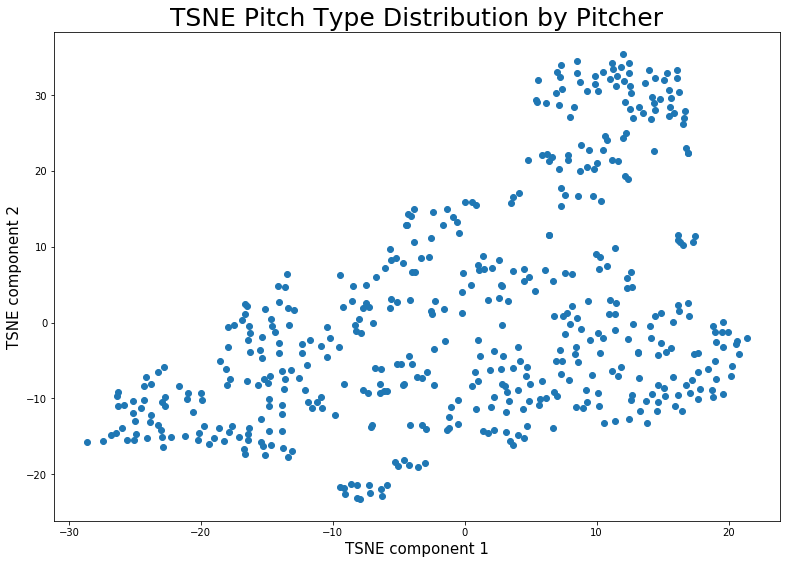

In [87]:
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1])  #scatterplot of tsne componenets
plt.title('TSNE Pitch Type Distribution by Pitcher', size=25)
plt.xlabel('TSNE component 1', size=15)
plt.ylabel('TSNE component 2', size=15)

## Kmeans on TSNE components

For n_clusters = 2 The average silhouette_score is : 0.42446914


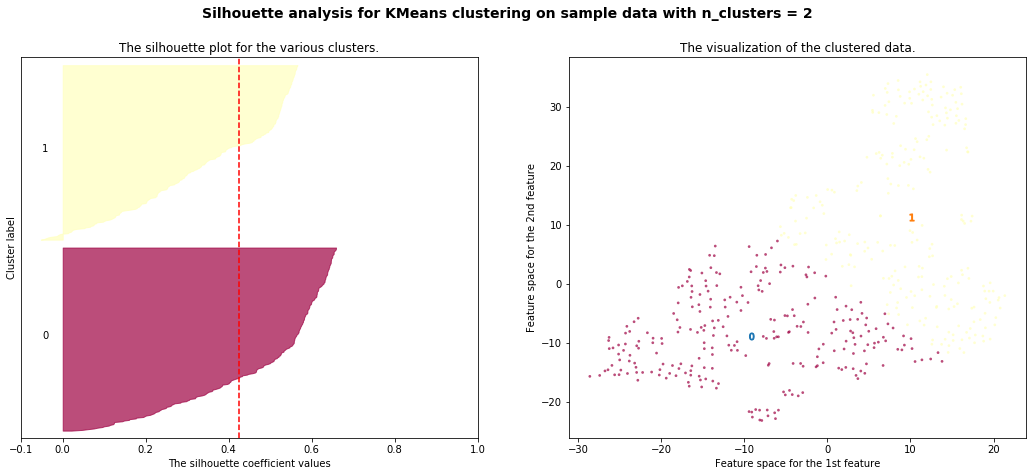

For n_clusters = 3 The average silhouette_score is : 0.48081574


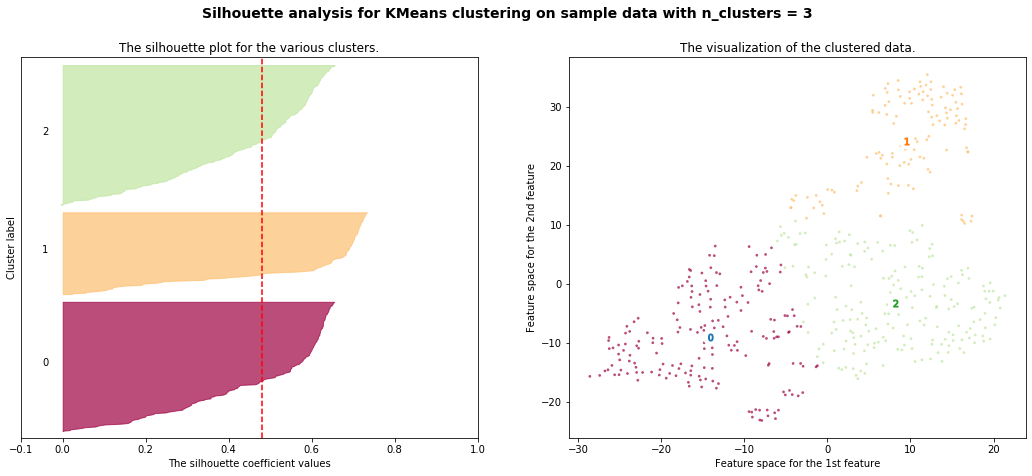

For n_clusters = 4 The average silhouette_score is : 0.46677363


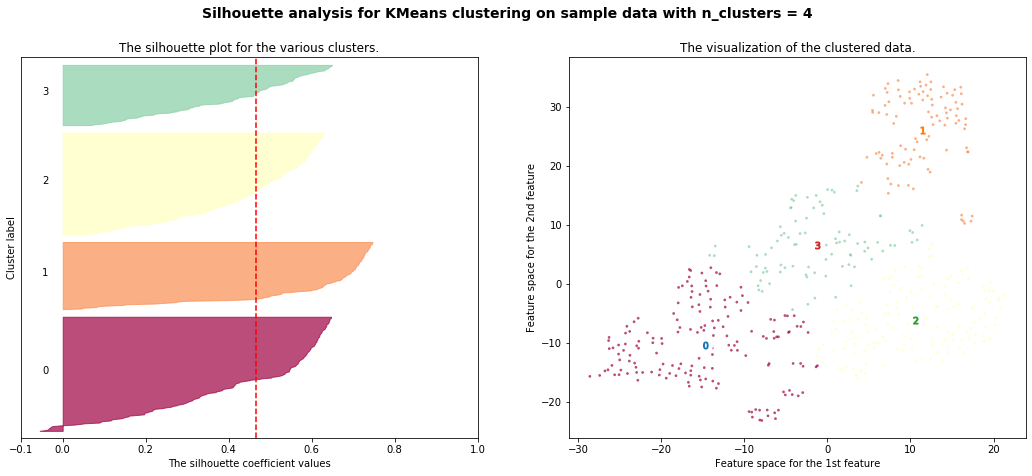

For n_clusters = 5 The average silhouette_score is : 0.46212572


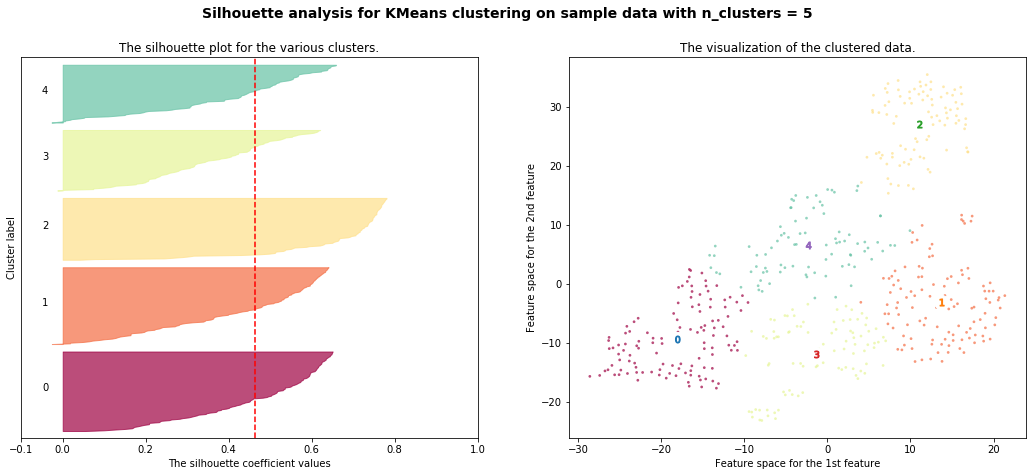

For n_clusters = 6 The average silhouette_score is : 0.44031802


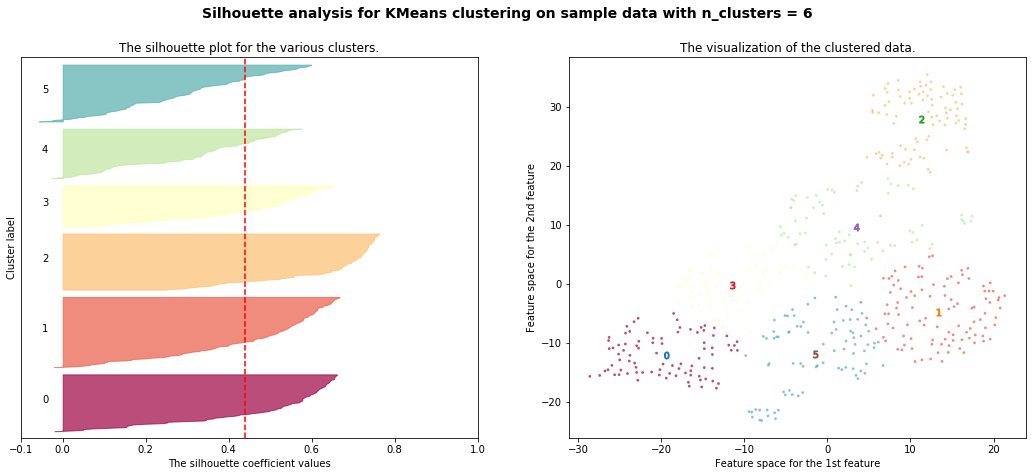

For n_clusters = 7 The average silhouette_score is : 0.42812446


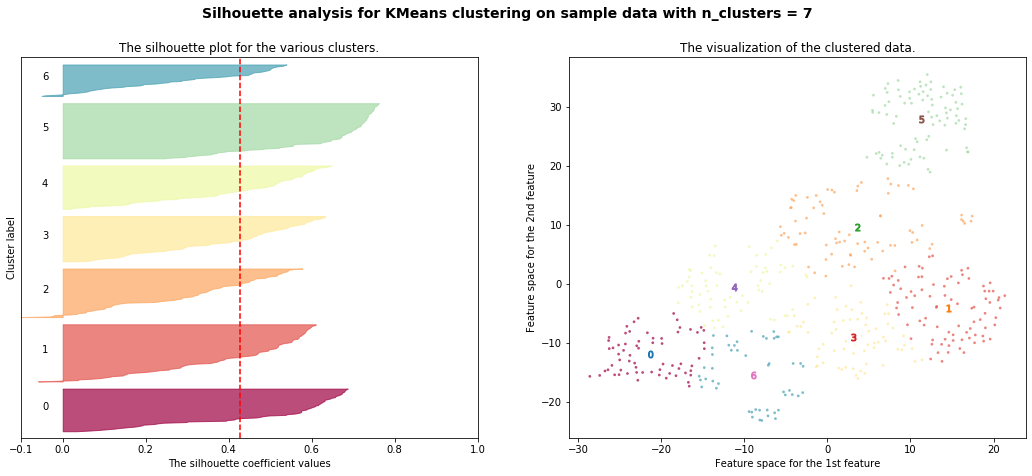

For n_clusters = 8 The average silhouette_score is : 0.43937793


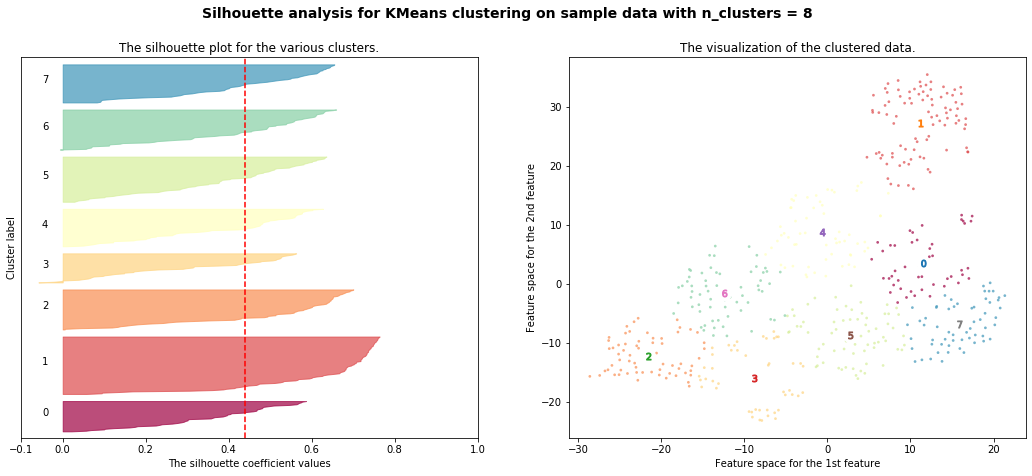

For n_clusters = 9 The average silhouette_score is : 0.41469762


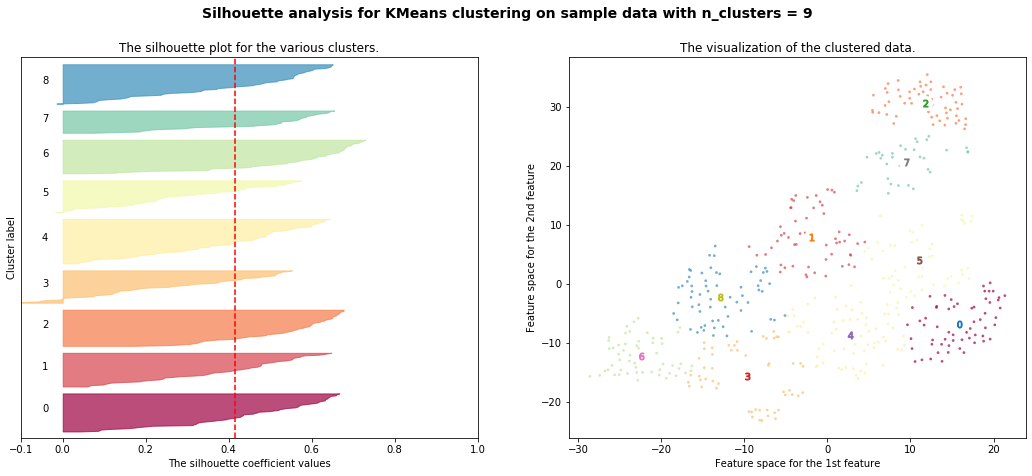

For n_clusters = 10 The average silhouette_score is : 0.42262873


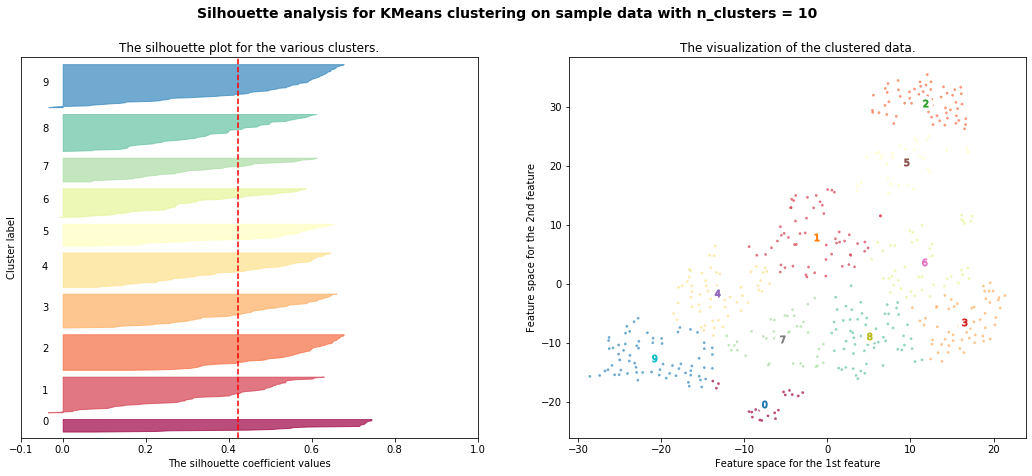

For n_clusters = 11 The average silhouette_score is : 0.41494536


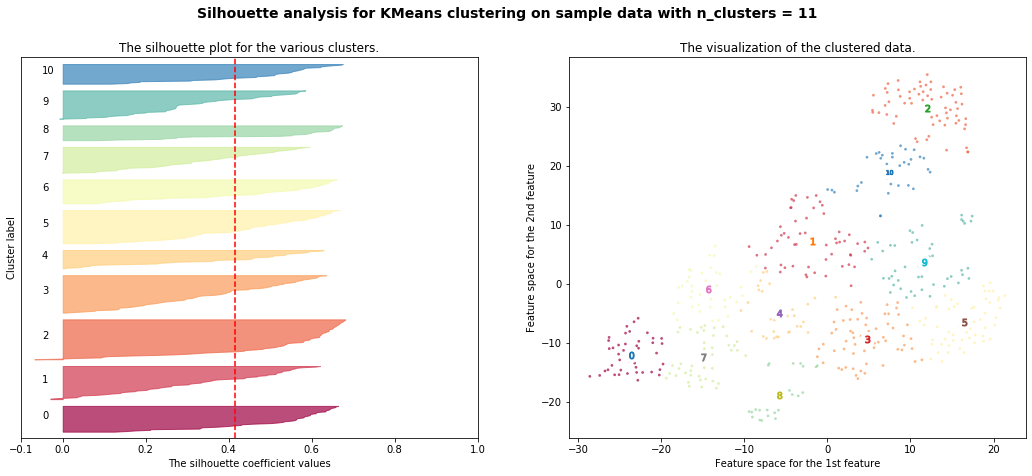

For n_clusters = 12 The average silhouette_score is : 0.41484487


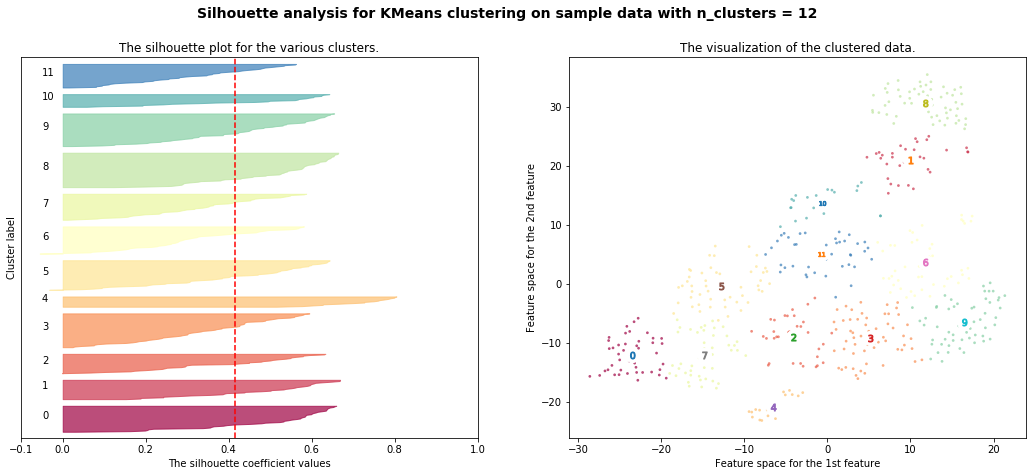

For n_clusters = 13 The average silhouette_score is : 0.40502813


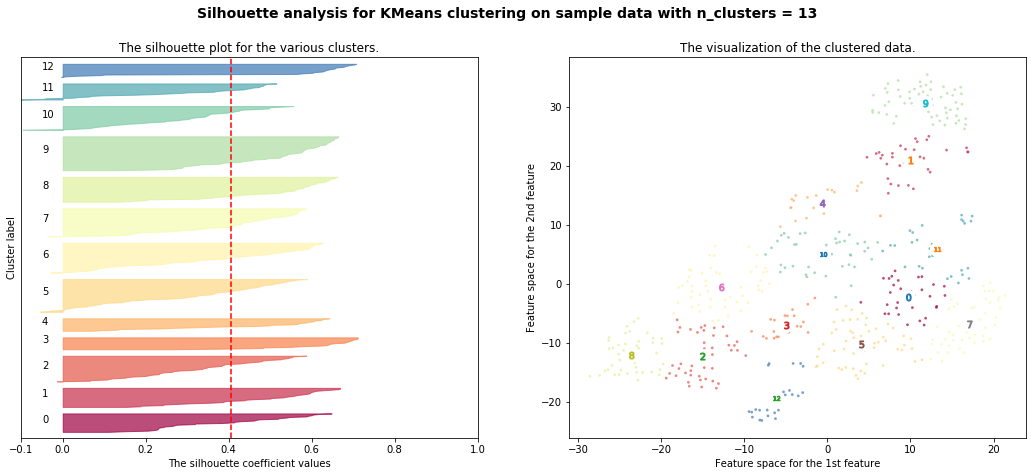

For n_clusters = 14 The average silhouette_score is : 0.415377


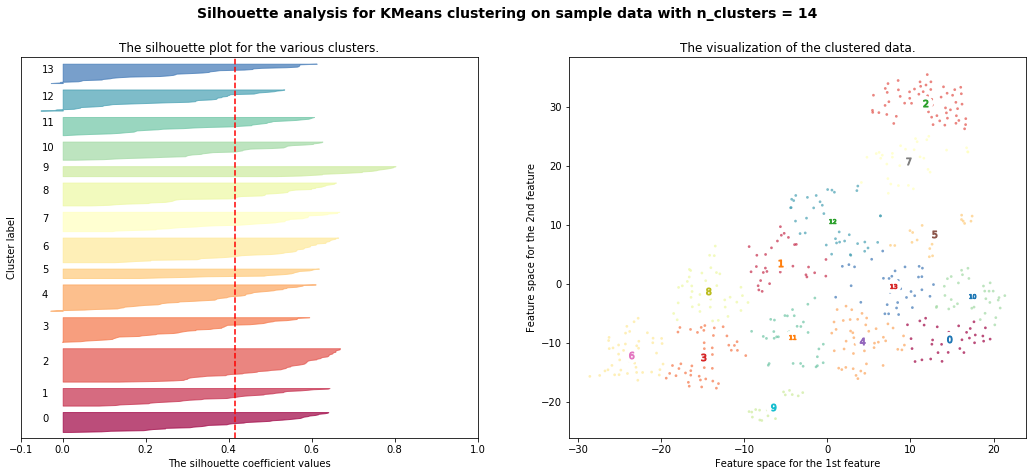

For n_clusters = 15 The average silhouette_score is : 0.4294765


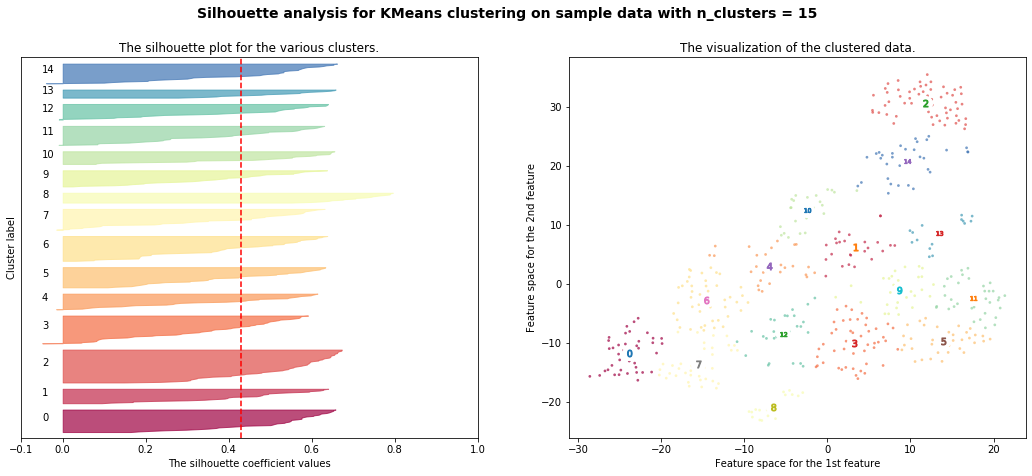

For n_clusters = 16 The average silhouette_score is : 0.41367894


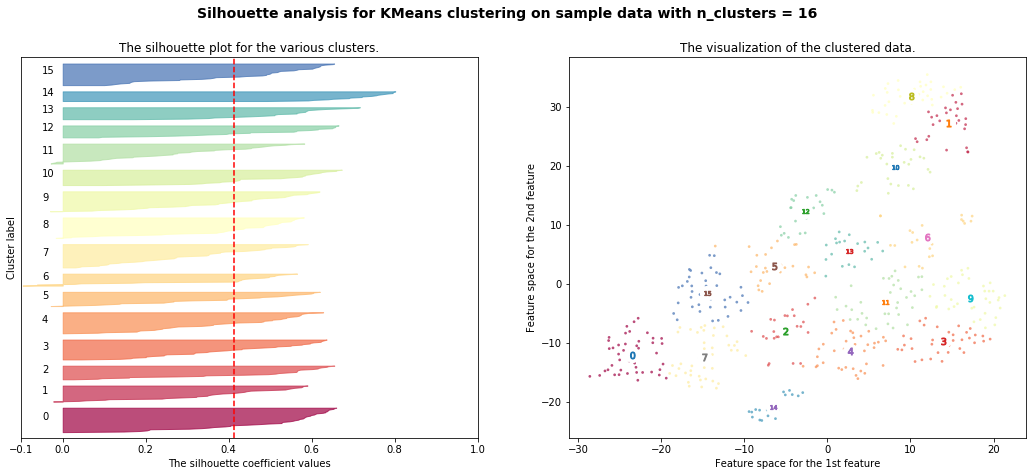

For n_clusters = 17 The average silhouette_score is : 0.4187981


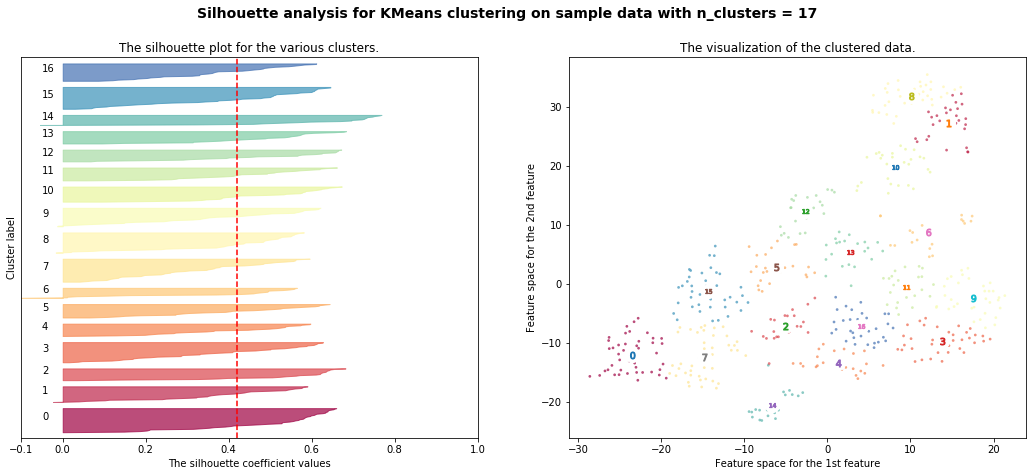

For n_clusters = 18 The average silhouette_score is : 0.4223531


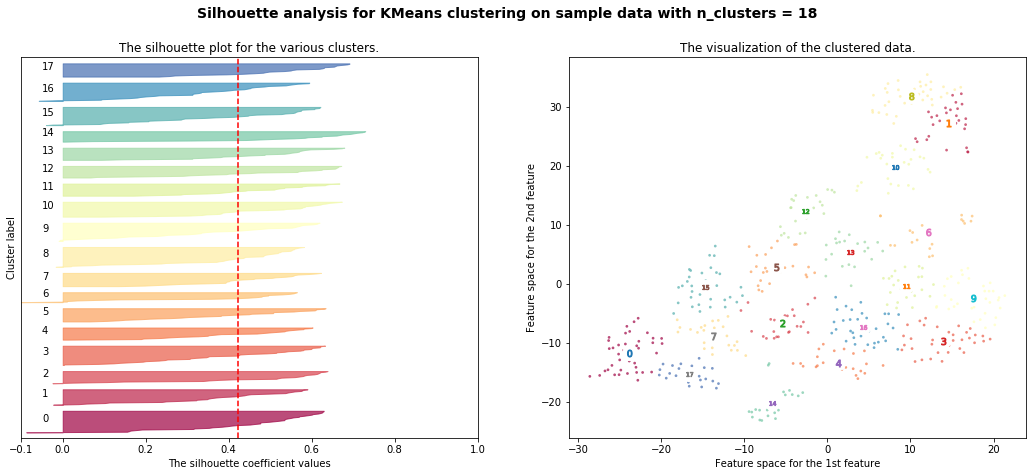

For n_clusters = 19 The average silhouette_score is : 0.42292652


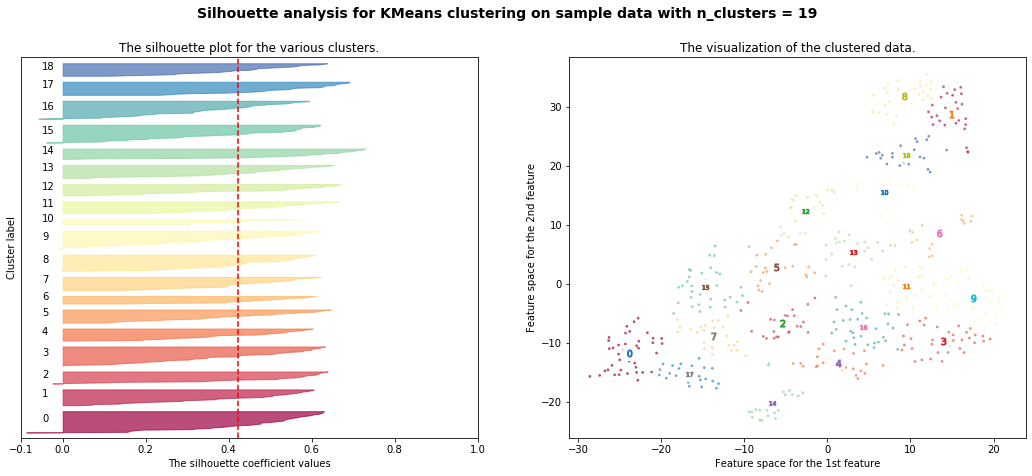

In [67]:
#thank you galvanize for the beautiful plotting kmeans code :)

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

X = tsne
range_n_clusters = range(2,20)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed

    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## 3 Kmeans Clusters

In [308]:
clusterer = KMeans(n_clusters=3, random_state=10)

cluster_labels = clusterer.fit_predict(X)  #labels for each pitcher 

In [309]:
clusterer.cluster_centers_  #centroids to compare to each tsne point

array([[-14.153882 ,  -9.076331 ],
       [  9.459446 ,  24.08505  ],
       [  8.100563 ,  -3.2924562]], dtype=float32)

In [310]:
df_accuracy_pitchers['kmeans_3'] = cluster_labels  #putting cluster labels into df to match with each pitcher

In [311]:
df_accuracy_pitchers['tsne_component1'] = tsne[:, 0]  #putting components into pitchers accuracy df
df_accuracy_pitchers['tsne_component2'] = tsne[:, 1]

Text(0.5, 1.0, 'Pitchers Accuracy by Cluster')

<Figure size 432x288 with 0 Axes>

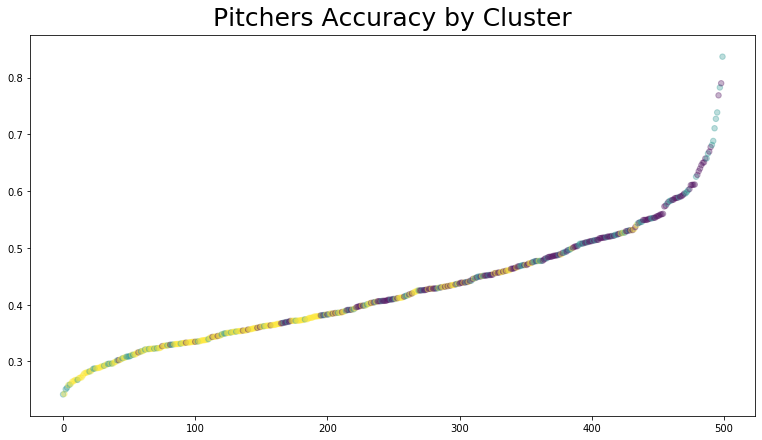

In [312]:
#plotting pitchers accuracy according to their cluster color
cmap = cm.get_cmap('viridis')
plt.set_cmap(cmap)
plt.figure(figsize=(13,7))
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['accuracy'].values, c=df_accuracy_pitchers['kmeans_3'].values, alpha=0.3, s=30)
plt.title('Pitchers Accuracy by Cluster', size=25, pad=10)
plt.xlabel('Pitchers', size=15)
plt.ylabel('CV Accuracy')

Text(0.5, 1.0, 'Number of Pitchers in each Cluster')

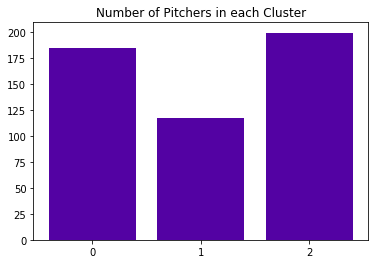

In [313]:
#plot of number of pitchers in each cluster
plt.bar(df_accuracy_pitchers.groupby('kmeans_3').count().iloc[:, 0].index, df_accuracy_pitchers.groupby('kmeans_3').count().iloc[:, 0].values)
plt.xticks([0,1,2])
plt.title('Number of Pitchers in each Cluster')

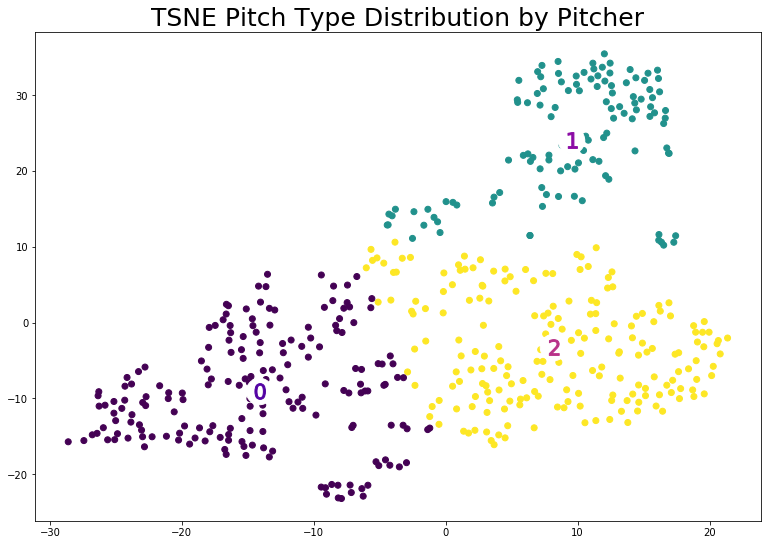

In [314]:
#tsne components plot by cluster 
centers = clusterer.cluster_centers_
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.title('TSNE Pitch Type Distribution by Pitcher', size=25)

plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=700)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=250)
plt.set_cmap('viridis')

In [315]:
#saving current pitchers accuracy df as csv
df_accuracy_pitchers.to_csv('../Models/final_tsne_cluster_pitchers.csv')

## Need to do lots of EDA to figure out why pitchers are categorized together

In [92]:
label_0 = df_accuracy_pitchers[df_accuracy_pitchers['kmeans_3'] == 0]
label_1 = df_accuracy_pitchers[df_accuracy_pitchers['kmeans_3'] == 1]
label_2 = df_accuracy_pitchers[df_accuracy_pitchers['kmeans_3'] == 2]

<Figure size 432x288 with 0 Axes>

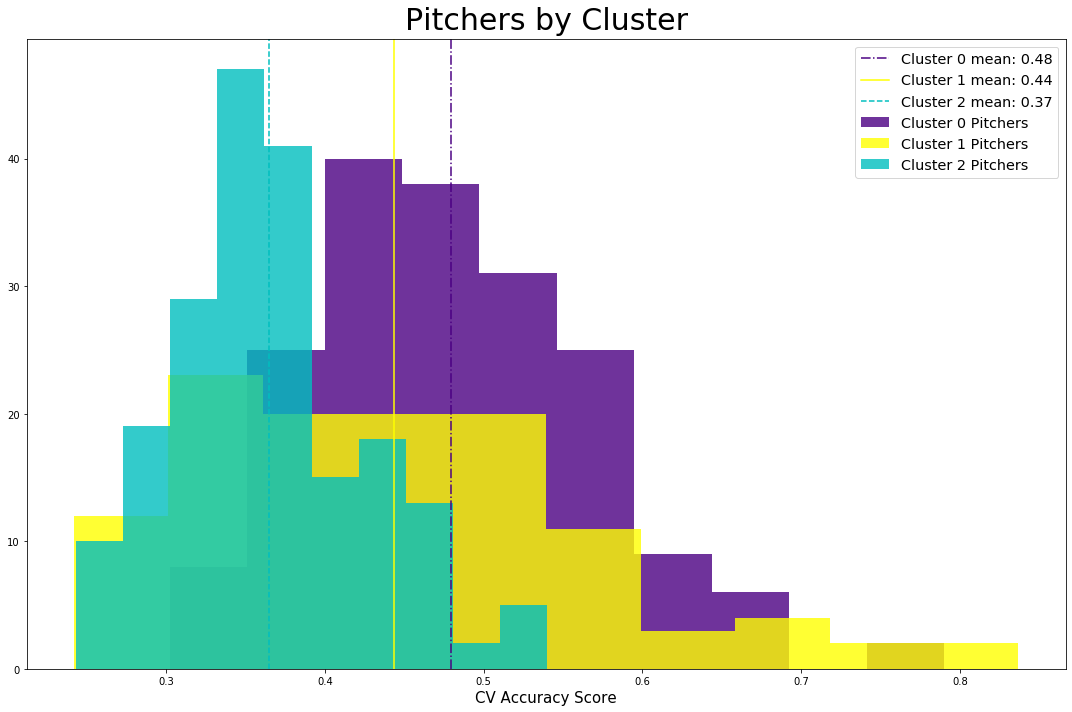

In [363]:
plt.set_cmap('viridis')
plt.figure(figsize=(15, 10))
plt.hist(label_0['accuracy'], label='Cluster 0 Pitchers', alpha=0.8, color='indigo')
plt.hist(label_1['accuracy'], label='Cluster 1 Pitchers', alpha=0.8, color='yellow')
plt.hist(label_2['accuracy'], label='Cluster 2 Pitchers', alpha=0.8, color='c')

plt.axvline(np.mean(label_0['accuracy']), ls= '-.', label='Cluster 0 mean: {:2.2f}'.format(np.mean(label_0['accuracy'])), c='indigo')
plt.axvline(np.mean(label_1['accuracy']), ls='-', label='Cluster 1 mean: {:2.2f}'.format(np.mean(label_1['accuracy'])), c='yellow')
plt.axvline(np.mean(label_2['accuracy']), ls='--', label='Cluster 2 mean: {:2.2f}'.format(np.mean(label_2['accuracy'])), c='c')
plt.xlabel('CV Accuracy Score', size=15)
plt.title('Pitchers by Cluster', size=30, pad=10)
plt.legend(fontsize='x-large')
plt.tight_layout()
#plt.set_cmap('viridis')
plt.savefig('../Graphics/pitcher_historgam_bycluster.png', dpi=100)

In [357]:
cluster_0_acc = np.mean(label_0['accuracy'])
cluster_1_acc = np.mean(label_1['accuracy'])
cluster_2_acc = np.mean(label_2['accuracy'])


### Inferences about Cluster Pitching Accuracy Means 

In [358]:
print('Mean Accuracy of Cluster 0 Pitchers: {:2.2f}'.format(cluster_0_acc))
print('Mean Accuracy of Cluster 1 Pitchers: {:2.2f}'.format(cluster_1_acc))
print('Mean Accuracy of Cluster 2 Pitchers: {:2.2f}'.format(cluster_2_acc))

Mean Accuracy of Cluster 0 Pitchers: 0.48
Mean Accuracy of Cluster 1 Pitchers: 0.44
Mean Accuracy of Cluster 2 Pitchers: 0.37


In [161]:
#take a look at what pitchers are close to this node
clusterer.cluster_centers_

array([[-14.153882 ,  -9.076331 ],
       [  9.459446 ,  24.08505  ],
       [  8.100563 ,  -3.2924562]], dtype=float32)

In [160]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(clusterer.cluster_centers_, tsne)
closest

array([364,  24,  29])

In [156]:
# closest pitcher to centroid 0
df_accuracy_pitchers.iloc[364, :]

name                 Reynaldo Lopez
accuracy                   0.479656
num_pitches                    4654
batting_avg_agnst          0.228809
kmeans_3                          0
tsne_component1            -13.7305
tsne_component2            -8.80268
Name: 364, dtype: object

In [157]:
#closest pitcher to centroid 1
df_accuracy_pitchers.iloc[24, :]

name                 CC Sabathia
accuracy                0.287609
num_pitches                10449
batting_avg_agnst       0.234977
kmeans_3                       1
tsne_component1          8.80834
tsne_component2          23.3683
Name: 24, dtype: object

In [158]:
#closest pitcher to centroid 2
df_accuracy_pitchers.iloc[29, :]

name                 Wade Miley
accuracy               0.291207
num_pitches               10265
batting_avg_agnst      0.247599
kmeans_3                      2
tsne_component1         8.45513
tsne_component2        -3.21433
Name: 29, dtype: object

No handles with labels found to put in legend.


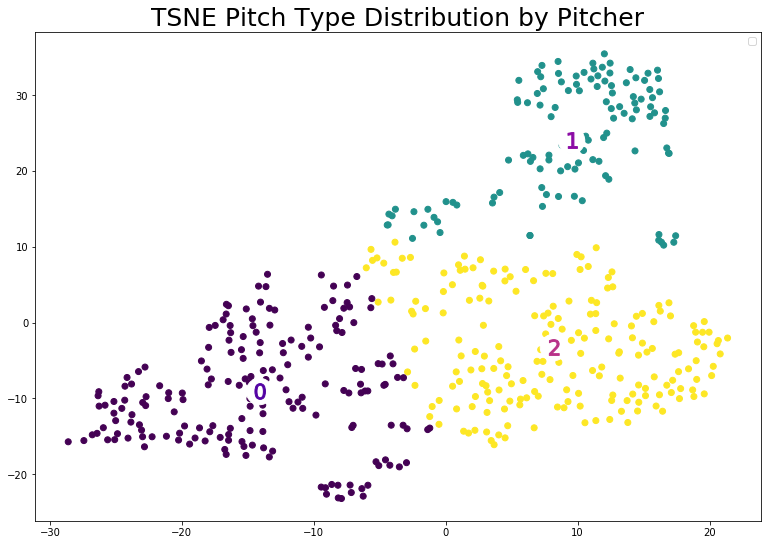

In [343]:
#tsne components plot by cluster 

centers = clusterer.cluster_centers_
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster_labels)
plt.title('TSNE Pitch Type Distribution by Pitcher', size=25)

plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=700)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=250)
    
plt.legend()

### Plotting each centroid Pitcher and their distribution of pitches

In [206]:
#grabs only centroid pitchers and their vectors
df = final_vectors.iloc[[364, 24, 29], :].T.reset_index()

In [276]:
df

name_y,index,Reynaldo Lopez,CC Sabathia,Wade Miley
0,AB,0.000000,0.000000,0.000000
1,CH,0.163300,0.111111,0.160740
2,CU,0.103137,0.000000,0.112226
3,EP,0.000000,0.000000,0.000000
4,FA,0.000000,0.000000,0.000000
5,FC,0.000000,0.172648,0.092742
6,FF,0.608294,0.167384,0.298782
7,FO,0.000215,0.000000,0.000000
8,FS,0.000000,0.000000,0.000000
9,FT,0.002364,0.000000,0.196006


In [214]:
#pd melt to get df to a point eto put into sns
dfs = pd.melt(df, id_vars='index')
dfs.rename(columns={'name_y':'Pitcher'}, inplace=True)

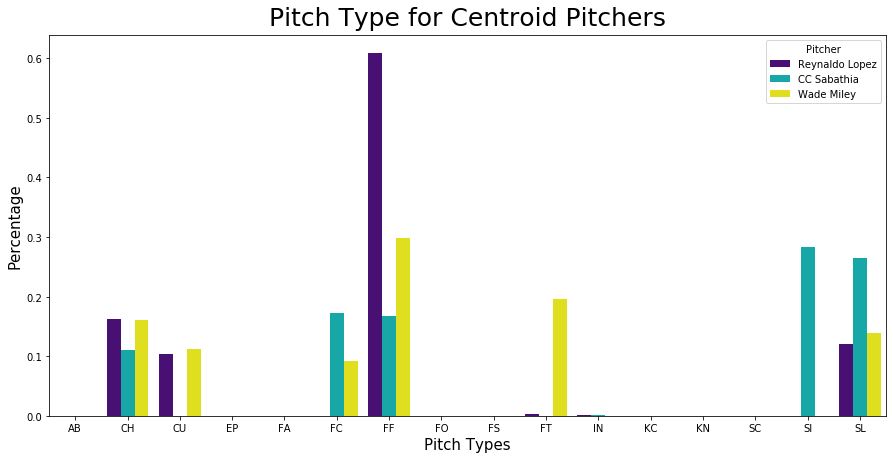

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
palette ={"Reynaldo Lopez":"indigo","CC Sabathia":"c","Wade Miley":"yellow"}
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.set_palette('plasma')
sns.factorplot(x = 'index', y='value', hue = 'Pitcher',data=dfs, kind='bar', ax=ax, palette=palette)
ax.set_title('Pitch Type for Centroid Pitchers', size=25, pad=10)
plt.set_cmap('viridis')
plt.tight_layout()
plt.close(2)
plt.xlabel('Pitch Types', size=15)
plt.ylabel('Percentage', size=15)
plt.savefig('../Graphics/pitch_distribution_centroid_pitchers.png', dpi=100);

In [267]:
index_0 = np.where(df_accuracy_pitchers['kmeans_3'] == 0)[0]
index_1 = np.where(df_accuracy_pitchers['kmeans_3'] == 1)[0]
index_2 = np.where(df_accuracy_pitchers['kmeans_3'] == 2)[0]

In [278]:
series_0 = final_vectors.iloc[index_0, :].sum(axis=0)
series_1 = final_vectors.iloc[index_1, :].sum(axis=0)
series_2 = final_vectors.iloc[index_2, :].sum(axis=0)

every_cluster_df = pd.concat((series_0, series_1, series_2), axis=1).reset_index()

In [327]:
every_cluster_df[0] = every_cluster_df[0] /np.sum(every_cluster_df[0])
every_cluster_df[1] = every_cluster_df[1] /np.sum(every_cluster_df[1])
every_cluster_df[2] = every_cluster_df[2] /np.sum(every_cluster_df[2])

In [328]:
every_cluster_df

,index,0,1,2
0,AB,0.000001,0.000005,0.000002
1,CH,0.093127,0.096241,0.107428
2,CU,0.081821,0.069229,0.084380
3,EP,0.000009,0.000561,0.000231
4,FA,0.000005,0.000000,0.000003
5,FC,0.027155,0.090028,0.057702
6,FF,0.544834,0.127778,0.314297
7,FO,0.001414,0.000277,0.000248
8,FS,0.024844,0.007732,0.011125
9,FT,0.035485,0.028942,0.235338


In [329]:
dfs2 = pd.melt(every_cluster_df, id_vars='index')

In [330]:
dfs2['variable'] = dfs2['variable'].astype(str)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


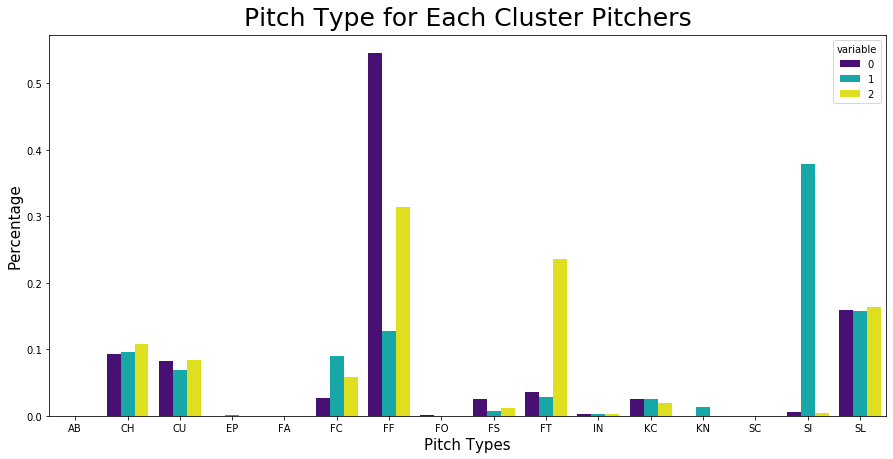

In [364]:
palette ={"0":"indigo","1":"c","2":"yellow"}
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.factorplot(x = 'index', y='value', hue = 'variable',data=dfs2, kind='bar', ax=ax, palette=palette)
ax.set_title('Pitch Type for Each Cluster Pitchers', size=25, pad=10)
plt.tight_layout()
plt.close(2)
plt.xlabel('Pitch Types', size=15)
plt.ylabel('Percentage', size=15)
plt.savefig('../Graphics/pitch_distribution_centroid_pitchers.png', dpi=100);

## Try 15 Kmeans clusters

In [301]:
clusterer15 = KMeans(n_clusters=15, random_state=10)

cluster_labels15 = clusterer15.fit_predict(X) 

In [302]:
df_accuracy_pitchers['kmeans_15'] = cluster_labels15

Text(0.5, 1.0, 'Number of Pitchers in each Cluster')

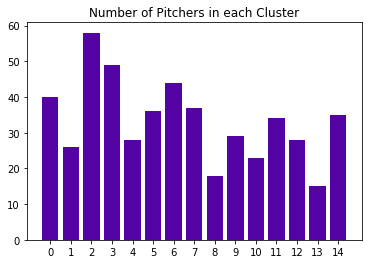

In [304]:
plt.bar(df_accuracy_pitchers.groupby('kmeans_15').count().iloc[:, 0].index, df_accuracy_pitchers.groupby('kmeans_15').count().iloc[:, 0].values)
plt.xticks(np.arange(15))
plt.title('Number of Pitchers in each Cluster')

''

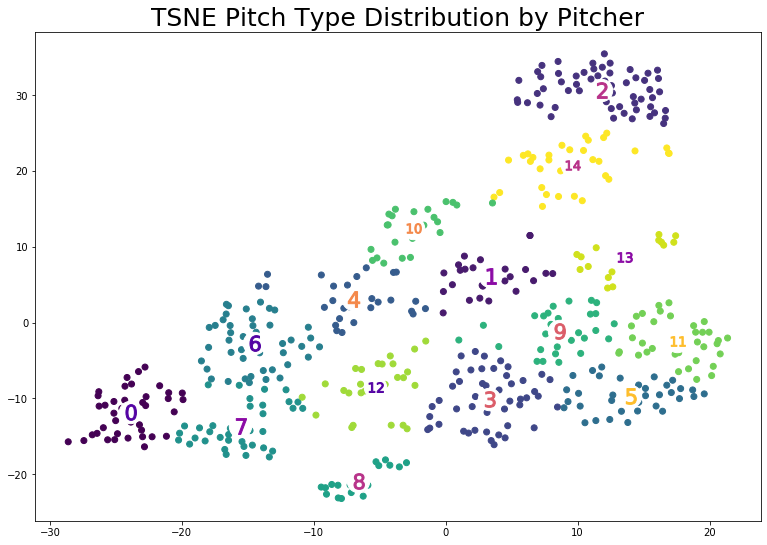

In [318]:
#tsne components plot by cluster 

centers = clusterer15.cluster_centers_
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster_labels15)
plt.title('TSNE Pitch Type Distribution by Pitcher', size=25)

plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=500)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=250)
;

Text(0.5, 1.0, 'Pitchers Accuracy by Cluster')

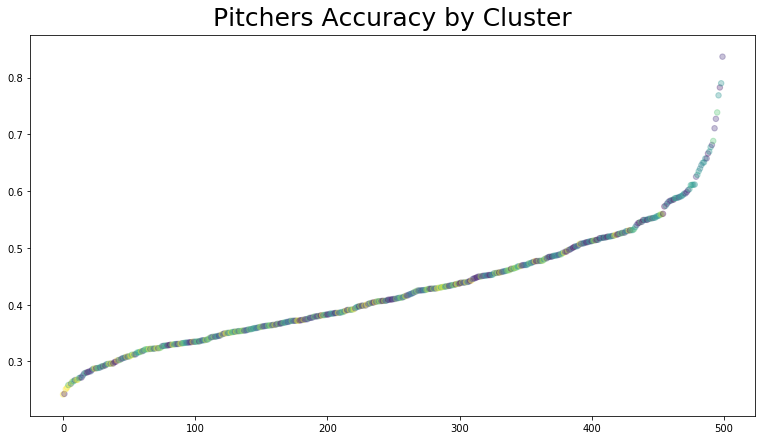

In [316]:
#plotting pitchers accuracy according to their cluster color
plt.figure(figsize=(13,7))
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['accuracy'].values, c=df_accuracy_pitchers['kmeans_15'].values, alpha=0.3, s=30)
plt.title('Pitchers Accuracy by Cluster', size=25, pad=10)

In [359]:
clusterer2 = KMeans(n_clusters=2, random_state=10)

cluster_labels2 = clusterer2.fit_predict(X) 

In [360]:
df_accuracy_pitchers['kmeans_2'] = cluster_labels2

''

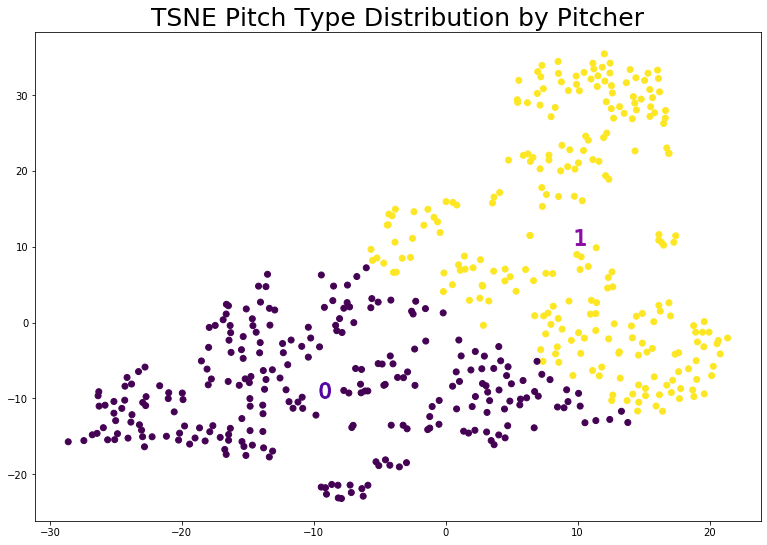

In [361]:
#tsne components plot by cluster 

centers = clusterer2.cluster_centers_
plt.figure(figsize=(13,9))
plt.scatter(tsne[:, 0], tsne[:, 1], c=cluster_labels2)
plt.title('TSNE Pitch Type Distribution by Pitcher 2', size=25)

plt.scatter(centers[:, 0], centers[:, 1],
            marker='o', c="white", alpha=1, s=500)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=250)
;

Text(0.5, 1.0, 'Pitchers Accuracy by Cluster with 2')

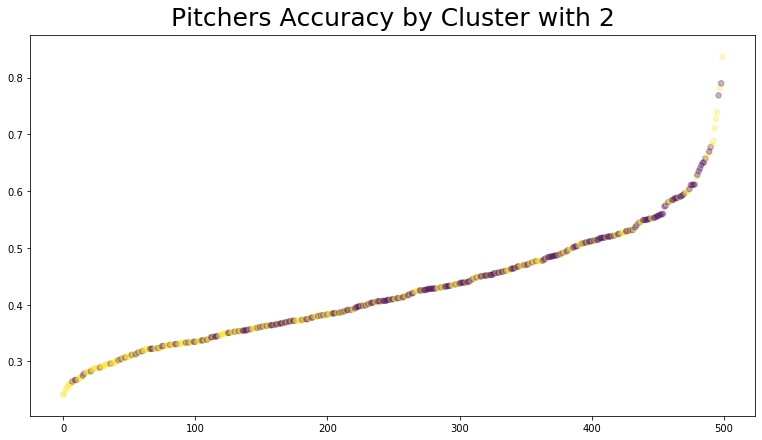

In [362]:
#plotting pitchers accuracy according to their cluster color
plt.figure(figsize=(13,7))
plt.scatter(df_accuracy_pitchers.index, df_accuracy_pitchers['accuracy'].values, c=df_accuracy_pitchers['kmeans_2'].values, alpha=0.3, s=30)
plt.title('Pitchers Accuracy by Cluster with 2', size=25, pad=10)